# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

### Цель лабораторной работы
Изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

### Задание
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
3. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
4. Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.
5. Сравните метрики качества исходной и оптимальной моделей.

# Загрузка данных

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

wine = load_wine()
for x in wine:
    print(x)

data
target
frame
target_names
DESCR
feature_names


In [2]:
data = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])

## Вывод верхних 5 строчек датасета

In [3]:
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


# Разделение выборки на обучающую и тестовую с использованием метода train_test_split

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(wine.data, wine.target, test_size=0.25, random_state=1)

In [5]:
# Размер обучающей выборки
X_train.shape, Y_train.shape

((133, 13), (133,))

In [6]:
# Размер тестовой выборки
X_test.shape, Y_test.shape

((45, 13), (45,))

Функция train_test_split разделила исходную выборку таким образом, чтобы в обучающей и тестовой частях сохранились все классы.

In [7]:
np.unique(Y_train)

array([0, 1, 2])

In [8]:
np.unique(Y_test)

array([0, 1, 2])

In [9]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    """
    Вычисляет пропорции классов
    array - массив, содержащий метки классов
    """
    # Получение меток классов и количества меток каждого класса 
    labels, counts = np.unique(array, return_counts=True)
    # Превращаем количество меток в процент их встречаемости
    # делим количество меток каждого класса на общее количество меток
    counts_perc = counts/array.size
    # Теперь sum(counts_perc)==1.0
    # Создаем результирующий словарь,
    # ключом словаря явлется метка класса, 
    # а значением словаря процент встречаемости метки
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    """
    Вывод пропорций классов
    """
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [10]:
print_class_proportions(wine.target)

# Функция train_test_split разделила исходную выборку таким образом, 
# чтобы в обучающей и тестовой частях сохранились пропорции классов.

Метка 	 Количество 	 Процент встречаемости
0 	 59 	 	 33.15%
1 	 71 	 	 39.89%
2 	 48 	 	 26.97%


In [11]:
# Для обучающей выборки
print_class_proportions(Y_train)

Метка 	 Количество 	 Процент встречаемости
0 	 41 	 	 30.83%
1 	 54 	 	 40.6%
2 	 38 	 	 28.57%


In [12]:
# Для тестовой выборки
print_class_proportions(Y_test)

Метка 	 Количество 	 Процент встречаемости
0 	 18 	 	 40.0%
1 	 17 	 	 37.78%
2 	 10 	 	 22.22%


# Обучение модели ближайших соседей для произвольно заданного гиперпараметра K

In [13]:
# 3 ближайших соседа
# Метрика accuracy вычисляет процент (долю в диапазоне от 0 до 1) правильно определенных классов
cl1_1 = KNeighborsClassifier(n_neighbors=3)
cl1_1.fit(X_train, Y_train)
target1_0 = cl1_1.predict(X_train)
target1_1 = cl1_1.predict(X_test)
accuracy_score(Y_train, target1_0), accuracy_score(Y_test, target1_1)

(0.8646616541353384, 0.6888888888888889)

In [14]:
# 7 ближайших соседей
# Метрика accuracy вычисляет процент (долю в диапазоне от 0 до 1) правильно определенных классов
cl1_2 = KNeighborsClassifier(n_neighbors=7)
cl1_2.fit(X_train, Y_train)
target2_0 = cl1_2.predict(X_train)
target2_1 = cl1_2.predict(X_test)
accuracy_score(Y_train, target2_0), accuracy_score(Y_test, target2_1)

(0.7669172932330827, 0.6444444444444445)

# Построение модели с использованием кросс-валидации

In [15]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), wine.data, wine.target, cv=3)

# Значение метрики accuracy для 3 фолдов
scores

array([0.61666667, 0.57627119, 0.79661017])

In [16]:
# Усредненное значение метрики accuracy для 3 фолдов
np.mean(scores)

0.6631826741996233

In [17]:
# использование метрики precision
scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), 
                         wine.data, wine.target, cv=3,
                        scoring='precision_weighted')
scores, np.mean(scores)

(array([0.61631579, 0.59473992, 0.78926159]), 0.6667724311739814)

In [18]:
# функция cross_validate позволяет использовать для оценки несколько метрик
scoring = {'precision': 'precision_weighted', 
           'jaccard': 'jaccard_weighted',
           'f1': 'f1_weighted'}

scores = cross_validate(KNeighborsClassifier(n_neighbors=3), 
                        wine.data, wine.target, scoring=scoring, 
                        cv=3, return_train_score=True)
scores

{'fit_time': array([0., 0., 0.]),
 'score_time': array([0.0156188 , 0.03124356, 0.01560211]),
 'test_precision': array([0.61631579, 0.59473992, 0.78926159]),
 'train_precision': array([0.84432192, 0.87868395, 0.78719633]),
 'test_jaccard': array([0.44786325, 0.41520347, 0.66077488]),
 'train_jaccard': array([0.72223627, 0.78003999, 0.65344998]),
 'test_f1': array([0.60380952, 0.57731661, 0.78515946]),
 'train_f1': array([0.83420614, 0.87517928, 0.78484177])}

# Подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации

In [19]:
n_range = np.array(range(3,57,3))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51,
         54])}]

In [20]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(X_train, Y_train)

Wall time: 564 ms


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51,
       54])}],
             scoring='accuracy')

In [21]:
clf_gs.cv_results_

{'mean_fit_time': array([0.00312467, 0.00625453, 0.        , 0.00312428, 0.00312424,
        0.        , 0.        , 0.006249  , 0.        , 0.00312209,
        0.        , 0.        , 0.        , 0.0044302 , 0.00312443,
        0.        , 0.        , 0.        ]),
 'std_fit_time': array([0.00624933, 0.00766021, 0.        , 0.00624857, 0.00624847,
        0.        , 0.        , 0.00765343, 0.        , 0.00624418,
        0.        , 0.        , 0.        , 0.00614004, 0.00624886,
        0.        , 0.        , 0.        ]),
 'mean_score_time': array([0.        , 0.00311832, 0.00443697, 0.00312691, 0.00312438,
        0.00312433, 0.0044292 , 0.        , 0.00312643, 0.        ,
        0.001302  , 0.00937481, 0.00312409, 0.00625587, 0.00312395,
        0.00624857, 0.00442619, 0.00937696]),
 'std_score_time': array([0.        , 0.00623665, 0.00615026, 0.00625381, 0.00624876,
        0.00624866, 0.00614316, 0.        , 0.00625286, 0.        ,
        0.00260401, 0.0076545 , 0.00624819, 

In [22]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=45)

In [23]:
# Лучшее значение метрики
clf_gs.best_score_

0.7435897435897435

In [24]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 45}

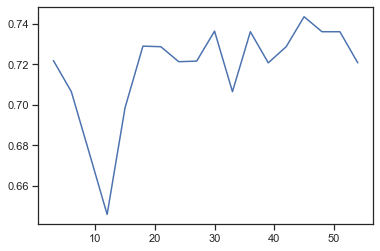

In [25]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

Таким образом, оптимальный гиперпараметр K = 45.

# Сравнение метрики качества исходной и оптимальной моделей

## Accuracy

Метрика вычисляет процент (долю в диапазоне от 0 до 1) правильно определенных классов.

Эту метрику обычно переводят как "точность", но перевод не является удачным, потому что совпадает с переводом для другой метрики - "precision".

Чтобы не сталкиваться с неточностями перевода, названия метрик можно не переводить.

In [26]:
# Y_test - эталонное значение классов из исходной (тестовой) выборки
# target* - предсказанное значение классов

# 3 ближайших соседа
accuracy_score(Y_test, target1_1)

0.6888888888888889

In [27]:
# 7 ближайших соседей
accuracy_score(Y_test, target2_1)

0.6444444444444445

In [28]:
# Y_train - значение классов из тренировочной выборки
# target* - предсказанное значение классов

# 3 ближайших соседа
accuracy_score(Y_train, target1_0)

0.8646616541353384

In [29]:
# 7 ближайших соседей
accuracy_score(Y_train, target2_0)

0.7669172932330827

Метрика "Accuracy" показывает точность по всем классам, но точность может быть различной для различных классов.
Это очень серьезная проблема, которая часто возникает на несбалансированных выборках.

In [30]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [31]:
# 3 ближайших соседа
print_accuracy_score_for_classes(Y_test, target1_1)

Метка 	 Accuracy
0 	 0.8333333333333334
1 	 0.7058823529411765
2 	 0.4


### Accuracy для классов 0 составляет 83%, 1 составляет 71%, но для класса 2 только 40%.

In [32]:
# 7 ближайших соседей
print_accuracy_score_for_classes(Y_test, target2_1)

Метка 	 Accuracy
0 	 0.7777777777777778
1 	 0.5882352941176471
2 	 0.5


### Accuracy для классов 0 составляет 78%, 1 составляет 59%, но для класса 2 только 50%.

# Обучим нашу модель на найденном лучшем параметре и проведем сравнение

In [33]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
clf_gs.best_estimator_.fit(X_train, Y_train)
target3_0 = clf_gs.best_estimator_.predict(X_train)
target3_1 = clf_gs.best_estimator_.predict(X_test)

In [34]:
# Новое качество модели
accuracy_score(Y_train, target3_0), accuracy_score(Y_test, target3_1)

(0.7368421052631579, 0.6888888888888889)

In [35]:
# Качество модели до подбора гиперпараметров (7)
accuracy_score(Y_train, target2_0), accuracy_score(Y_test, target2_1)

(0.7669172932330827, 0.6444444444444445)

In [36]:
# Качество модели до подбора гиперпараметров (3)
accuracy_score(Y_train, target1_0), accuracy_score(Y_test, target1_1)

(0.8646616541353384, 0.6888888888888889)